<h1><center>Course 1 Honors Project: Sam Laquerre </center></h1>


In [1]:
# Importing all needed packages and the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import seaborn as sns
import re

filepath = "golf_data/pgafulldata.csv"
data = pd.read_csv(filepath, encoding='latin1')

## Dataset Summary
This dataset contains the statistics for the top 200 PGA Tour players from 2015-2019. The original dataset comprises of 29 columns with stats about every aspect of their game, including driving distance, putts per round, proximity to the hole, and many more.

## Dataset Plan
Many golf instructors around the world constantly debate which aspect of the golf game is most crucial for success. Using the dataset, we will find data-driven conclusions as to which statistics led to the lowest scoring averages. 

## Data Cleaning and Feature Engineering
Below are listed all of the actions taken to clean the data and implement new features:
- Any row with a null value in the scoring average was removed since that is the target feature
- Any distance related metric that was measured in feet and inches was converted to a decimal in feet
- This dataset included a lot superfluous statistics that do not relate to performance, so any of those are removed

In [2]:
#Removing any rows without a scoring average (target value)
data.dropna(subset=['Scoring Average'], inplace=True)

#Seperating the name column into a name and year column
def obj_to_int(obj):
    if pd.isna(obj):
        return None
    
    return int(obj)

data['Player Name'] = data['PLAYER NAME'].str.extract(r'^(.*) \(\d{4}\)$')
data['Year'] = data['PLAYER NAME'].str.extract(r'\((\d{4})\)')
data['Year'] = data['Year'].apply(obj_to_int)

#Function to convert distance to a decimal
def feet_inches_string_to_decimal(ft_inches_str):
    if pd.isna(ft_inches_str) or ft_inches_str.strip == "":
        return None
    
    clean_str = ft_inches_str.replace("'", "")
    clean_str = clean_str.replace("\"", "")
    parts = clean_str.split(" ")
    if len(parts) != 2:
        return None
    
    height = 0
    height += int(parts[0]) + float(int(parts[1])/12)
    return height

#Convert all feet and inches columns to decimals using the function above
data['Decimal Approach from > 100 Yards (Feet)'] = data['Approaches from > 100 yards'].apply(feet_inches_string_to_decimal)
data['Average Distance Putts Made (Feet)'] = data['Average Distance of Putts made'].apply(feet_inches_string_to_decimal)
data['Decimal Proximity to Hole (Feet)'] = data['Proximity to Hole'].apply(feet_inches_string_to_decimal)
    

#Removing all unecessary columns
data.drop(columns=['Eagles (Holes per)', 'FedexCup Regular Season Points', 'Official Money',
                   'Total Birdies', 'Total Eagles', 'Top 10 Finishes', 'Country', 'College', 
                   'PLAYER NAME', 'Approaches from > 100 yards', 'Average Distance of Putts made',
                   'Proximity to Hole'], inplace=True)

## Key Findings and Insights
After doing some EDA, discovering the correlation coefficients of the data and doing some visualizations, here are some preliminary insights on this dataset:
- Making birdies is crucial, which may be a straighforward assumption but this conclusion does back a more aggresive playstyle that has been promoted in the modern era of golf
- Surprisingly, of the scoring averages on each type of hole (par 3/4/5), par 4's seem to have the strongest correlation with better scores. Perhaps it is due to the difficulty of these holes, but that is something to be explored by our model.
- Being an all around player. Driving distance seems to have very low correlation with better scores, same with putts per round. This seems to conclude that instead of hyperfocusing on one aspect of your game, all should receive equal time and practice.

C:\Users\sslaq\AppData\Local\Temp\ipykernel_119224\210856507.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


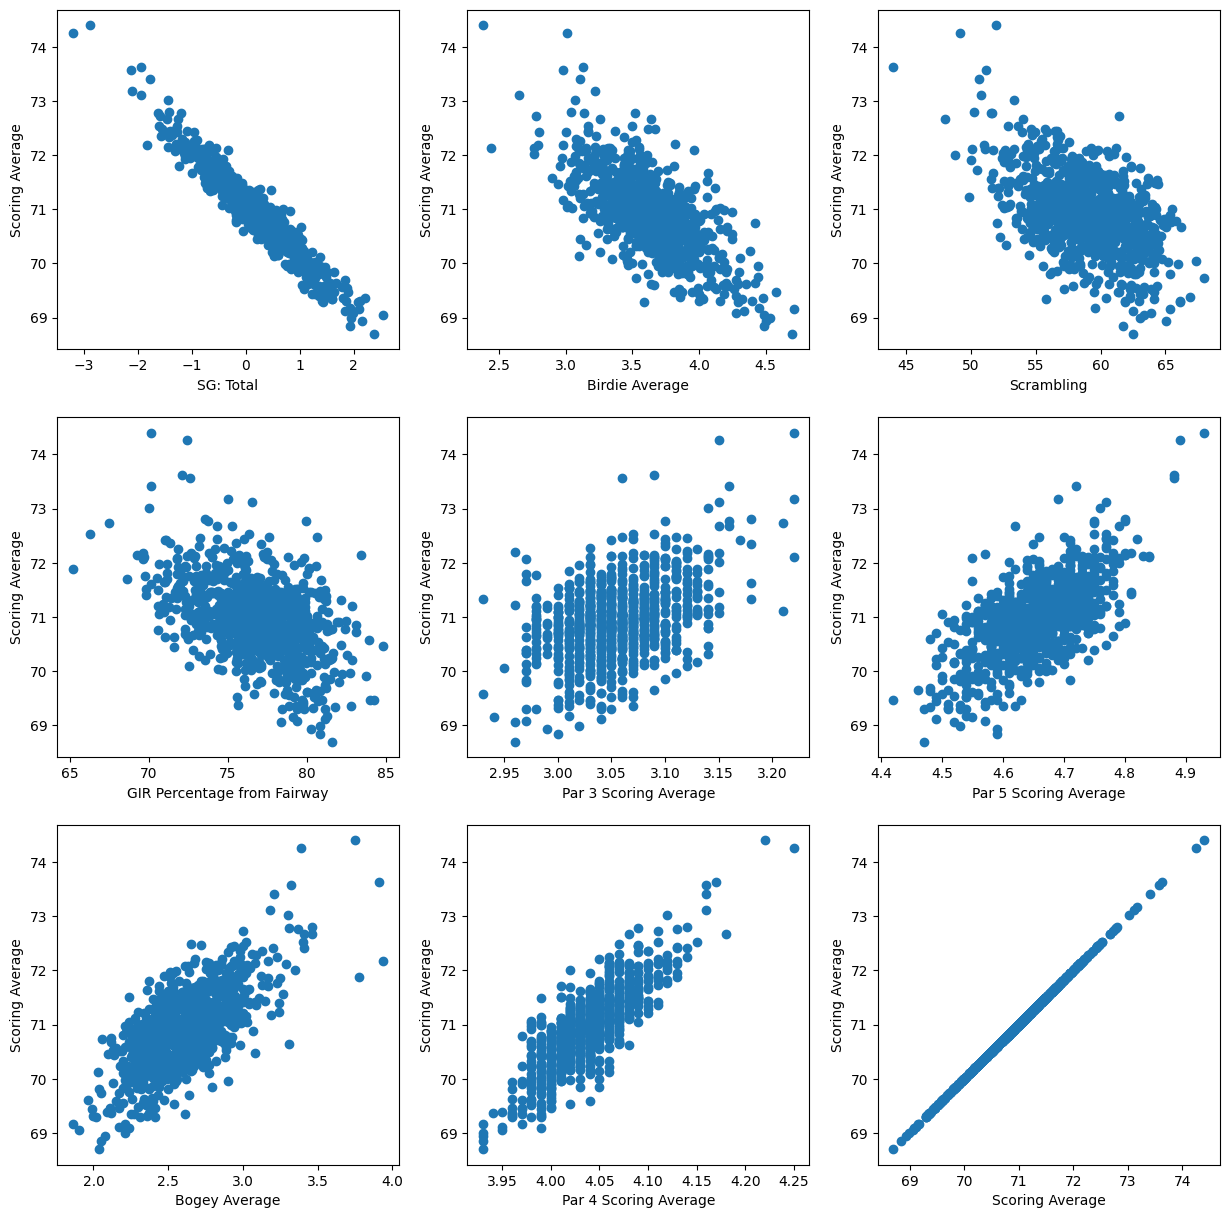

In [3]:
#Creating a correlation matrix and determining which features are most strongly correlated to scoring average
num_data = data.select_dtypes(include=['float64', 'int64'])
score_corr = num_data.corr()['Scoring Average']
high_score_corr = score_corr[abs(score_corr) > 0.4].sort_values()

#Year by Year Insights:
numeric_data = data.select_dtypes(include='number')
year_data = numeric_data.groupby('Year').mean()

#Graphs for highly correlated features
rows = int(np.ceil(len(high_score_corr) // 3))
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

if rows > 1:
    ax = ax.flatten()
else:
    ax = [ax]
    
for i, stat in enumerate(list(high_score_corr.index)):
    ax[i].scatter(data[stat], data['Scoring Average'])
    ax[i].set(xlabel=f'{stat}', ylabel="Scoring Average")
fig.show()

## Hypothesis About The Data
#### Test 1: Driving the ball over 300 yards will give you a lower scoring average than on Tour
#### Test 2: Scoring less than or equal to 4.55 on the par 5's results in a lower average than on Tour
#### Test 3: Making above 3 bogeys a around will give you a higher average than on Tour

### The following code will conduct Test 1, below are the two hypotheses
Null: Players who drive the ball over 300 yards have a scoring average greater than or equal to a half stroke less than Tour Average
Alternate: Players who drive the ball over 300 yards have a lower scoring average than half a stroke less than Tour Average

To determine whether we can reject the null hypothesis or not, a left-tailed test will be conducted below to determine the p-value.

In [4]:
#Establish an alpha value for the test
alpha = 0.05

#Create the lists of averages for both the tour and those 300+ yard averages
tour_avg = list(data['Scoring Average'])
long_avg = list(data[data['Driving Distance'] > 300]['Scoring Average'])

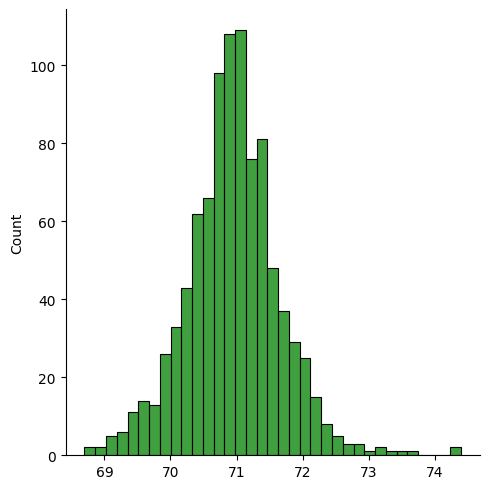

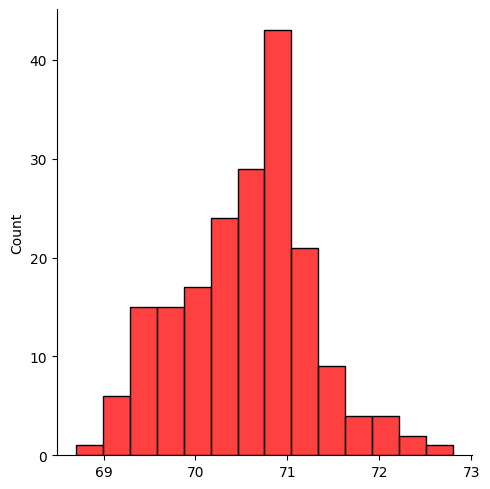

In [5]:
#Graph the data for a visualization
sns.displot(tour_avg, color='green')
sns.displot(long_avg, color='red')

Based on the above visualizations, we can make an early prediction that we will not be able to reject the null hypothesis since the graphs look nearly identical!

In [6]:
#Perform the test

#Calculate means and std's
tour_mean = np.mean(tour_avg)
long_mean = np.mean(long_avg)
std_tour = np.std(tour_avg)
std_long = np.std(long_avg)

#sample sizes
tourN = len(tour_avg)
longN = len(long_avg)
se = np.sqrt((std_tour**2/tourN) + (std_long**2/longN))

#Calculate z-score(Both samples have a length of above 30)
z_stat = (long_mean - (tour_mean - 0.5)) / se

p_value = scp.stats.norm.cdf(z_stat)

if p_value < 0.05:
    print(f'We can reject the null hypothesis and conclude that players who hit the ball above 300 yards on average have a lower score with a p-value of {p_value}')
else:
    print(f'There is not sufficient evidence to conclude that longer hitters have lower scoring averages with a p-value of {p_value}')

There is not sufficient evidence to conclude that longer hitters have lower scoring averages with a p-value of 0.965611558723723


As shown above, we can confidently accept the null hypothesis and in fact determine that a longer driving distance does not correlate to a lower scoring average. There has been a lot of attention recently surrounding whether chasing longer drives is really beneficial, and this concludes with certainty that it does not since it cannot even save 0.5 strokes.

## Next Steps for this Dataset:
Most of the feature engineering has been completed for this dataset there would only be a couple things I would suggest before moving on:
- Figure out how to scale all of the features as needed for the machine learning model
- Do more investigation and see if any of the features correlate to one another (i.e longer driving distance = lower scoring on par 5's?)

## Final Remarks
Overall, the initial quality of the dataset upon receiving it was not the greatest. There were many null values and many columns that were in string format. After cleaning up the null values and doing the necessary conversions, it is a much cleaner and more workable dataset. The year by year feature is also incredibly helpful, as it allows us to identify trends that may be useful when we're inputting data into the machine learning model later on. There should be no additional data required.